<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/Kenyan_Supermaket_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Group 2 [Hope Subira, Alphones Onditi, Jairus Otana, Jasper Obwaya]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:

df=pd.read_csv("/content/drive/MyDrive/Kenya_Supermarkets.csv")

In [ ]:

print("=== KENYAN SUPERMARKET DATA EXPLORATION ===")
print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names ({len(df.columns)} columns):")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")


=== KENYAN SUPERMARKET DATA EXPLORATION ===
Dataset Shape: (1192, 27)

Column Names (27 columns):
1. supermarket
2. no_of_items
3. variation
4. total
5. paid
6. change
7. type
8. food
9. snack
10. beverage
11. consumables
12. high_end
13. asset
14. fixed_asset
15. date
16. mall
17. time
18. time_type
19. type_market
20. location
21. loc_category
22. day
23. day_type
24. 24hr
25. day.1
26. month
27. year


In [ ]:
# Create features for clustering
features = pd.DataFrame()

# 1. Basic numerical features (these should be safe)
features['transaction_value'] = df['total'].astype(float)
features['number_of_items'] = df['no_of_items'].astype(float)
features['avg_item_price'] = (df['total'] / df['no_of_items'].replace(0, 1)).astype(float)  # Avoid division by zero

In [ ]:
# 2. PROPERLY handle binary columns - check what values they actually contain
binary_columns = ['food', 'snack', 'beverage', 'consumables', 'high_end', 'asset', 'fixed_asset', '24hr']

print("\n=== CHECKING BINARY COLUMNS ===")
for col in binary_columns:
    if col in df.columns:
        unique_vals = df[col].unique()
        print(f"{col}: {unique_vals}")

        # Convert based on actual values found
        if set(unique_vals).issubset({'yes', 'no'}):
            features[f'{col}'] = df[col].map({'yes': 1, 'no': 0}).fillna(0).astype(float)
        elif set(unique_vals).issubset({1, 0, '1', '0'}):
            features[f'{col}'] = df[col].astype(float)
        else:
            print(f"  Warning: {col} has unexpected values: {unique_vals}")
            # Skip this column or use label encoding
            le = LabelEncoder()
            features[f'{col}'] = le.fit_transform(df[col].astype(str)).astype(float)



=== CHECKING BINARY COLUMNS ===
food: ['yes' 'no']
snack: ['no' 'yes']
beverage: ['no' 'yes']
consumables: ['yes' 'no']
high_end: ['yes' 'no']
asset: ['no' 'yes']
fixed_asset: ['no' 'yes']
24hr: ['yes' 'no']


In [ ]:
# 3. Safely encode categorical variables
if 'time_type' in df.columns:
    print(f"\ntime_type values: {df['time_type'].unique()}")
    # Create a safe mapping
    time_values = df['time_type'].unique()
    time_mapping = {val: idx for idx, val in enumerate(time_values)}
    print(f"Time mapping: {time_mapping}")
    features['time_encoded'] = df['time_type'].map(time_mapping).fillna(0).astype(float)

if 'day_type' in df.columns:
    print(f"day_type values: {df['day_type'].unique()}")
    day_mapping = {'Weekday': 0, 'Weekend': 1}
    features['is_weekend'] = df['day_type'].map(day_mapping).fillna(0).astype(float)

# 4. Handle store_type columns safely
if 'type_market' in df.columns:
    print(f"\ntype_market values: {df['type_market'].unique()}")
    # Use proper one-hot encoding
    store_dummies = pd.get_dummies(df['type_market'].astype(str), prefix='store_type')
    # Convert boolean to float
    store_dummies = store_dummies.astype(float)
    features = pd.concat([features, store_dummies], axis=1)

print("\n=== FINAL FEATURES DATA TYPES ===")
print(features.dtypes)
print(f"Features shape: {features.shape}")

# Verify all columns are numeric
print("\n=== VERIFYING ALL NUMERIC ===")
for col in features.columns:
    if not pd.api.types.is_numeric_dtype(features[col]):
        print(f"WARNING: Column {col} is not numeric: {features[col].dtype}")
        print(f"  Unique values: {features[col].unique()}")
    else:
        print(f"✓ {col}: {features[col].dtype}")


time_type values: ['afternoon' 'night' 'morning' 'evening']
Time mapping: {'afternoon': 0, 'night': 1, 'morning': 2, 'evening': 3}
day_type values: ['weekday']

type_market values: ['chain' 'median' 'small']

=== FINAL FEATURES DATA TYPES ===
transaction_value    float64
number_of_items      float64
avg_item_price       float64
food                 float64
snack                float64
beverage             float64
consumables          float64
high_end             float64
asset                float64
fixed_asset          float64
24hr                 float64
time_encoded         float64
is_weekend           float64
store_type_chain     float64
store_type_median    float64
store_type_small     float64
dtype: object
Features shape: (1192, 16)

=== VERIFYING ALL NUMERIC ===
✓ transaction_value: float64
✓ number_of_items: float64
✓ avg_item_price: float64
✓ food: float64
✓ snack: float64
✓ beverage: float64
✓ consumables: float64
✓ high_end: float64
✓ asset: float64
✓ fixed_asset: float64
✓ 

In [ ]:
# Handle any missing values
features = features.fillna(0)

# Remove any infinite values
features = features.replace([np.inf, -np.inf], 0)

# DOUBLE CHECK: Ensure all data is numeric
print("Final data types check before scaling:")
print(features.dtypes)

# If any columns are still not numeric, force convert them
non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"Converting non-numeric columns: {non_numeric_cols}")
    for col in non_numeric_cols:
        # Try to convert to numeric, force errors to NaN then fill with 0
        features[col] = pd.to_numeric(features[col], errors='coerce').fillna(0)

# Final verification
print("\n=== FINAL VERIFICATION ===")
print("All columns numeric:", all(pd.api.types.is_numeric_dtype(features[col]) for col in features.columns))

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

print("Scaled features summary:")
print(features_scaled.describe().round(3))

Final data types check before scaling:
transaction_value    float64
number_of_items      float64
avg_item_price       float64
food                 float64
snack                float64
beverage             float64
consumables          float64
high_end             float64
asset                float64
fixed_asset          float64
24hr                 float64
time_encoded         float64
is_weekend           float64
store_type_chain     float64
store_type_median    float64
store_type_small     float64
dtype: object

=== FINAL VERIFICATION ===
All columns numeric: True
Scaled features summary:
       transaction_value  number_of_items  avg_item_price      food     snack  \
count           1192.000         1192.000        1192.000  1192.000  1192.000   
mean               0.000           -0.000           0.000     0.000    -0.000   
std                1.000            1.000           1.000     1.000     1.000   
min               -0.307           -0.465          -0.608    -0.938    -0.717   

In [ ]:

print("\nFirst 5 rows:")
print(df.head())



First 5 rows:
  supermarket  no_of_items  variation    total   paid  change   type food  \
0    nakumatt           22          3   5611.0   5611     0.0   card  yes   
1  chandarana           32          3   7955.0   7955     0.0  mpesa  yes   
2    nakumatt            1          1    780.0   1000   220.0   cash   no   
3      acacia            1          1    235.0    500   265.0   cash   no   
4      tuskys           33          6  13005.0  13001     0.0   card  yes   

  snack beverage  ...  time_type type_market  location loc_category  \
0    no       no  ...  afternoon       chain       cbd          mid   
1    no       no  ...      night      median      yaya         high   
2    no       no  ...      night       chain  kilimani         high   
3    no       no  ...  afternoon       small     saika          mid   
4    no       no  ...    morning       chain   donholm          mid   

         day day_type 24hr day.1 month    year  
0  wednesday  weekday  yes    24    12  2016.0

In [ ]:

print("\nData Types and Missing Values:")
print(df.info())

print("\nMissing Values Summary:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

print("\nBasic Statistics for Numerical Columns:")
print(df.describe())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   supermarket   1192 non-null   object 
 1   no_of_items   1192 non-null   int64  
 2   variation     1192 non-null   int64  
 3   total         1192 non-null   float64
 4   paid          1192 non-null   int64  
 5   change        1192 non-null   float64
 6   type          1192 non-null   object 
 7   food          1192 non-null   object 
 8   snack         1192 non-null   object 
 9   beverage      1192 non-null   object 
 10  consumables   1192 non-null   object 
 11  high_end      1192 non-null   object 
 12  asset         1192 non-null   object 
 13  fixed_asset   1192 non-null   object 
 14  date          1192 non-null   object 
 15  mall          1192 non-null   object 
 16  time          1192 non-null   object 
 17  time_type     1192 non-null   object 
 

**Feature Engineering for Transaction Segmentation**

In [ ]:
# Create features for clustering
features = pd.DataFrame()

# 1. Transaction Value Features
features['transaction_value'] = df['total']
features['number_of_items'] = df['no_of_items']
features['avg_item_price'] = df['total'] / df['no_of_items']

# 2. Product Mix Features (what type of products are bought)
product_cols = ['food', 'snack', 'beverage', 'consumables', 'high_end', 'asset', 'fixed_asset']
for col in product_cols:
    if col in df.columns:
        features[f'has_{col}'] = df[col]  # Assuming these are binary or count columns

# 3. Time-based Features
if 'time_type' in df.columns:
    # Convert time categories to numerical (assuming categories like 'Morning', 'Afternoon', 'Evening')
    time_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2}
    features['time_encoded'] = df['time_type'].map(time_mapping).fillna(0)

if 'day_type' in df.columns:
    # Convert day type (Weekday/Weekend)
    day_mapping = {'Weekday': 0, 'Weekend': 1}
    features['is_weekend'] = df['day_type'].map(day_mapping).fillna(0)

# 4. Store Type Features
if 'type_market' in df.columns:
    store_dummies = pd.get_dummies(df['type_market'], prefix='store_type')
    features = pd.concat([features, store_dummies], axis=1)

print("Features for clustering:")
print(features.columns.tolist())
print(f"Features shape: {features.shape}")

Features for clustering:
['transaction_value', 'number_of_items', 'avg_item_price', 'has_food', 'has_snack', 'has_beverage', 'has_consumables', 'has_high_end', 'has_asset', 'has_fixed_asset', 'time_encoded', 'is_weekend', 'store_type_chain', 'store_type_median', 'store_type_small']
Features shape: (1192, 15)


**Determine Optimal Clusters**

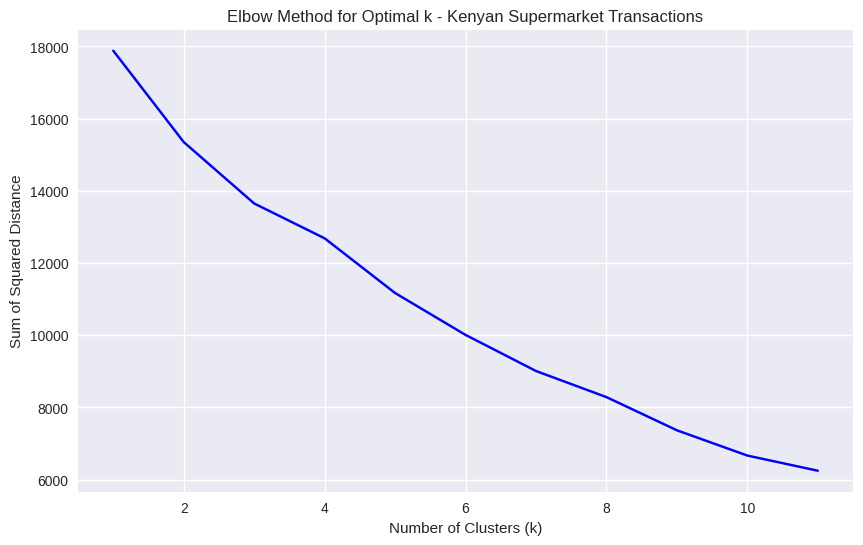

SSE reductions (look for the 'elbow' where reduction slows):
k=2: SSE reduction = 2530.04
k=3: SSE reduction = 1700.94
k=4: SSE reduction = 964.96
k=5: SSE reduction = 1514.93
k=6: SSE reduction = 1160.10
k=7: SSE reduction = 999.93
k=8: SSE reduction = 723.28
k=9: SSE reduction = 918.58
k=10: SSE reduction = 700.12

Selected optimal k: 4


In [ ]:
# Elbow Method
sse = {}
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    sse[k] = kmeans.inertia_

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distance')
plt.title('Elbow Method for Optimal k - Kenyan Supermarket Transactions')
plt.grid(True)
plt.show()

# Calculate the difference to help identify the elbow
sse_diff = {}
for k in range(2, 11):
    sse_diff[k] = sse[k-1] - sse[k]

print("SSE reductions (look for the 'elbow' where reduction slows):")
for k, diff in sse_diff.items():
    print(f"k={k}: SSE reduction = {diff:.2f}")

# Based on the elbow plot, choose optimal k
optimal_k = 4  # Adjust this based on where your elbow point is
print(f"\nSelected optimal k: {optimal_k}")

**Apply K-Means Clustering**

In [ ]:
# Apply K-Means with chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to original data
df['Cluster'] = cluster_labels
features['Cluster'] = cluster_labels

print(f"Clustering completed with {optimal_k} clusters")
cluster_distribution = df['Cluster'].value_counts().sort_index()
print(f"Cluster distribution:\n{cluster_distribution}")
print(f"Percentage distribution:\n{(cluster_distribution / len(df) * 100).round(1)}%")

Clustering completed with 4 clusters
Cluster distribution:
Cluster
0    144
1    403
2    135
3    510
Name: count, dtype: int64
Percentage distribution:
Cluster
0    12.1
1    33.8
2    11.3
3    42.8
Name: count, dtype: float64%


** Analyze and Profile Clusters**

In [ ]:
# First, let's fix the product mix columns in the features dataframe
print("=== FIXING PRODUCT MIX COLUMNS ===")

product_cols = ['food', 'snack', 'beverage', 'consumables', 'high_end', 'asset', 'fixed_asset']
for col in product_cols:
    feature_name = f'has_{col}'
    if feature_name in features.columns:
        print(f"Converting {feature_name}:")
        print(f"  Current type: {features[feature_name].dtype}")
        print(f"  Sample values: {features[feature_name].unique()[:5]}")

        # Convert 'yes'/'no' to 1/0
        if features[feature_name].dtype == object:
            features[feature_name] = features[feature_name].map({'yes': 1, 'no': 0}).fillna(0)
            print(f"  Converted to numeric: {features[feature_name].dtype}")
        else:
            print(f"  Already numeric: {features[feature_name].dtype}")

print("\n=== VERIFYING CONVERSION ===")
for col in product_cols:
    feature_name = f'has_{col}'
    if feature_name in features.columns:
        print(f"{feature_name}: {features[feature_name].dtype}, unique: {features[feature_name].unique()}")

# Now let's re-run the cluster analysis with fixed data
print("\n" + "="*50)
print("CLUSTER PROFILES (WITH FIXED DATA)")
print("="*50)

# 1. Basic transaction metrics by cluster (this worked fine)
basic_metrics = ['total', 'no_of_items', 'paid', 'change']
cluster_basic = df.groupby('Cluster')[basic_metrics].agg(['mean', 'std', 'count']).round(2)
print("Basic Transaction Metrics by Cluster:")
print(cluster_basic)

# 2. Key engineered features by cluster
key_features = ['transaction_value', 'number_of_items', 'avg_item_price', 'is_weekend']
key_features = [f for f in key_features if f in features.columns]
cluster_features = features.groupby('Cluster')[key_features].mean().round(3)
print("\nKey Features by Cluster:")
print(cluster_features)

# 3. Product mix analysis by cluster (NOW FIXED)
print("\n=== PRODUCT MIX BY CLUSTER ===")
product_features = [f'has_{col}' for col in product_cols if f'has_{col}' in features.columns]

if product_features:
    # Ensure all are numeric
    for col in product_features:
        features[col] = pd.to_numeric(features[col], errors='coerce').fillna(0)

    product_mix = features.groupby('Cluster')[product_features].mean().round(3)
    print("Average product presence by cluster (1 = always present, 0 = never present):")
    print(product_mix)

    # Identify dominant products for each cluster
    print("\n=== DOMINANT PRODUCT CATEGORIES BY CLUSTER ===")
    for cluster_id in range(optimal_k):
        cluster_products = product_mix.loc[cluster_id]
        top_products = cluster_products[cluster_products > 0.3]  # Products present in >30% of transactions
        if len(top_products) > 0:
            print(f"Cluster {cluster_id}: {', '.join([p.replace('has_', '') for p in top_products.index])}")
        else:
            print(f"Cluster {cluster_id}: No dominant product categories")

# 4. Time and store patterns
print("\n=== TIME AND STORE PATTERNS ===")
categorical_cols = ['time_type', 'day_type', 'type_market', 'location', 'mall']
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col} distribution by cluster:")
        cross_tab = pd.crosstab(df['Cluster'], df[col], normalize='index').round(3)
        print(cross_tab)

=== FIXING PRODUCT MIX COLUMNS ===
Converting has_food:
  Current type: object
  Sample values: ['yes' 'no']
  Converted to numeric: int64
Converting has_snack:
  Current type: object
  Sample values: ['no' 'yes']
  Converted to numeric: int64
Converting has_beverage:
  Current type: object
  Sample values: ['no' 'yes']
  Converted to numeric: int64
Converting has_consumables:
  Current type: object
  Sample values: ['yes' 'no']
  Converted to numeric: int64
Converting has_high_end:
  Current type: object
  Sample values: ['yes' 'no']
  Converted to numeric: int64
Converting has_asset:
  Current type: object
  Sample values: ['no' 'yes']
  Converted to numeric: int64
Converting has_fixed_asset:
  Current type: object
  Sample values: ['no' 'yes']
  Converted to numeric: int64

=== VERIFYING CONVERSION ===
has_food: int64, unique: [1 0]
has_snack: int64, unique: [0 1]
has_beverage: int64, unique: [0 1]
has_consumables: int64, unique: [1 0]
has_high_end: int64, unique: [1 0]
has_asset: i

In [ ]:
# Create meaningful segment names based on the cluster profiles
print("=== INTERPRETING CUSTOMER SEGMENTS ===")

segment_descriptions = {}
segment_characteristics = {}

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)

    # Key metrics
    avg_value = cluster_data['total'].mean()
    avg_items = cluster_data['no_of_items'].mean()
    overall_avg_value = df['total'].mean()
    overall_avg_items = df['no_of_items'].mean()

    # Get product preferences if available
    product_preferences = []
    if product_features:
        cluster_products = features[features['Cluster'] == cluster_id][product_features].mean()
        for product, ratio in cluster_products.items():
            if ratio > 0.5:  # Present in more than 50% of transactions
                product_preferences.append(product.replace('has_', ''))

    # Determine segment type based on spending and behavior
    if avg_value > overall_avg_value * 2:  # More than 2x average spending
        if avg_items > overall_avg_items:
            segment_type = "High-Value Family Shoppers"
            description = "Large families or bulk buyers making substantial purchases"
        else:
            segment_type = "Premium/Luxury Shoppers"
            description = "Affluent customers buying high-value items in smaller quantities"
    elif avg_value > overall_avg_value:
        segment_type = "Regular Loyal Customers"
        description = "Steady customers with above-average spending"
    else:
        if avg_items <= 2:
            segment_type = "Quick Convenience Shoppers"
            description = "Customers making quick, small purchases"
        else:
            segment_type = "Budget-Conscious Shoppers"
            description = "Price-sensitive customers buying essentials"

    segment_descriptions[cluster_id] = segment_type
    segment_characteristics[cluster_id] = {
        'description': description,
        'avg_spending': avg_value,
        'avg_items': avg_items,
        'product_preferences': product_preferences,
        'size': cluster_size,
        'percentage': (cluster_size / len(df)) * 100
    }

print("\n🎯 CUSTOMER SEGMENTS IDENTIFIED:")
print("="*60)

for cluster_id in range(optimal_k):
    char = segment_characteristics[cluster_id]
    print(f"\n📍 CLUSTER {cluster_id}: {segment_descriptions[cluster_id]}")
    print(f"   • Description: {char['description']}")
    print(f"   • Size: {char['size']} customers ({char['percentage']:.1f}% of total)")
    print(f"   • Average Spending: KES {char['avg_spending']:.2f} per transaction")
    print(f"   • Average Items: {char['avg_items']:.1f} per transaction")

    if char['product_preferences']:
        print(f"   • Preferred Products: {', '.join(char['product_preferences'])}")

    # Compare to overall averages
    spending_ratio = char['avg_spending'] / overall_avg_value
    items_ratio = char['avg_items'] / overall_avg_items

    if spending_ratio > 1.5:
        print(f"   • Spending: {spending_ratio:.1f}x higher than average")
    elif spending_ratio < 0.7:
        print(f"   • Spending: {spending_ratio:.1f}x lower than average")

    if items_ratio > 1.5:
        print(f"   • Basket Size: {items_ratio:.1f}x larger than average")

# Add segment names to dataframe
df['Segment'] = df['Cluster'].map(segment_descriptions)

=== INTERPRETING CUSTOMER SEGMENTS ===

🎯 CUSTOMER SEGMENTS IDENTIFIED:

📍 CLUSTER 0: High-Value Family Shoppers
   • Description: Large families or bulk buyers making substantial purchases
   • Size: 144 customers (12.1% of total)
   • Average Spending: KES 1378.68 per transaction
   • Average Items: 4.9 per transaction
   • Preferred Products: asset
   • Spending: 4.5x higher than average
   • Basket Size: 2.3x larger than average

📍 CLUSTER 1: Budget-Conscious Shoppers
   • Description: Price-sensitive customers buying essentials
   • Size: 403 customers (33.8% of total)
   • Average Spending: KES 205.25 per transaction
   • Average Items: 2.0 per transaction
   • Preferred Products: food
   • Spending: 0.7x lower than average

📍 CLUSTER 2: Quick Convenience Shoppers
   • Description: Customers making quick, small purchases
   • Size: 135 customers (11.3% of total)
   • Average Spending: KES 151.53 per transaction
   • Average Items: 1.7 per transaction
   • Spending: 0.5x lower tha